# Install Spark & initialize application

Run the following code to install Spark in your Colab environment.

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf spark-3.2.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"
import findspark
findspark.init()
findspark.find() # Should return '/content/spark-3.2.1-bin-hadoop2.7'

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
sc = spark.sparkContext

sc

# Spark: working with RDDs

Check the documentation: [here](https://spark.apache.org/docs/latest/api/python/reference/pyspark.html#rdd-apis).

## Basics

In [ ]:
# let's create a simple example
riddle1 = "over the bench the sheep lives under the bench the sheep dies"
riddle2 = ["over the bench the sheep lives", "under the bench the sheep dies"]

In [ ]:
# create an RDD from the `riddle` string
rdd1 = sc.parallelize(riddle1.split(" ")) 
# each tuple of the RDD corresponds to a single word

print(rdd1)
# why is there no result returned?

In [ ]:
# compute the RDD
print(rdd1.collect())

In [ ]:
rdd2 = sc.parallelize(riddle2) 
print(rdd2.collect())

## Transformations

In [ ]:
# map: returns a new RDD by applying a function to each of the elements in the original RDD
rdd1.map(lambda s: s.upper()).collect()

In [ ]:
# flatMap: returns a new RDD by applying the function to every element of the parent RDD and then flattening the result
rdd2.flatMap(lambda s: s.split(" ")).collect()

In [ ]:
# filter: returns a new RDD containing only the elements in the parent RDD that satisfy the function inside filter
rdd1.filter(lambda s: s.startswith("u")).collect()

In [ ]:
# distinct: returns a new RDD that contains only the distinct elements in the parent RDD
rdd1.distinct().collect()

In [ ]:
# groupByKey: groups the values for each key in the (key, value) pairs of the RDD into a single sequence
rdd1.map(lambda s: (s,1)).groupByKey().mapValues(list).collect()

# (first map converts to a key-value RDD)
# (mapValues is a map that operates only on the values - in this case, used to convert from ResultIterable to List for printing reasons)

In [ ]:
# reduceByKey: when called on a key-value RDD, returns a new dataset in which the values for each of its key are aggregated
rdd1.map(lambda s: (s,1)).reduceByKey(lambda x, y: x + y).collect()

In [ ]:
# sortByKey: returns a new RDD with (key,value) pairs of parent RDD in sorted order according to the key
rdd1.map(lambda s: (s,1)).sortByKey().collect()

In [ ]:
# join: starting from two RDD with (key, value1) and (key, value2) pairs, returns a new RDD with (key, (value1, value2)) pairs
rddA = sc.parallelize([(1, "A1"), (2, "A2"), (3, "A3")])
rddB = sc.parallelize([(1, "B1"), (2, "B2"), (4, "B4")])
rddA.join(rddB).collect()

## Actions

In [ ]:
# collect: returns a list that contains all the elements of the RDD
rdd1.collect()

In [ ]:
# count: returns the number of elements in the RDD
rdd1.count()

In [ ]:
# reduce: aggregates the elements of the RDD using a function that takes two elements of the RDD as input and gives the result
sc.parallelize([1, 2, 3, 4, 5]).reduce( lambda x, y: x * y)

In [ ]:
# take: returns the first n elements of RDD in the same order
rdd1.take(2)

In [ ]:
# saveAsTextFile: saves the content of the RDD to a file
rdd1.saveAsTextFile("rdd1")

## Examples

In [ ]:
# Flatten the words beginning with the letter C
# - map: transform each string in upper case (remember: map returns a new RDD with the same cardinality)
# - filter: keep only the strings beginning with "C" (remember: filter returns a new RDD with the same or smaller cardinality)
# - flatMap: explode each string into its characters (remember: flatMap returns a new RDD with the any cardinality)
rdd1\
    .map(lambda s: s.upper())\
    .filter(lambda s: s.startswith("U"))\
    .flatMap(lambda s: list(s))\
    .collect()

In [ ]:
# A simple word count
# - map: map each word to a tuple (word, 1); each tuple represent the count associate with a word
# - reduceByKey: group all the tuples with the same word and sum the counts
# - sortBy: sort tuples by count
rdd1\
    .map(lambda s: (s, 1))\
    .reduceByKey(lambda a, b: a + b)\
    .sortBy(lambda x: x[1], False)\
    .collect()

In [ ]:
# Compute average length of words depending on their initial letter
# map: map each word to a key-value tuple (word, (wordLength, 1)), where the value is an object composed by two value: the length of the word and a 1
# reduceByKey: group all the tuples with the same word to 1) sum the lengths, and 2) sum the counts
# mapValues: divides the sums by the counts to compute the averages
# sortBy: sort tuples by averages
rdd1\
  .map(lambda s: (s[0], (len(s),1)))\
  .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
  .mapValues(lambda x: x[0]/x[1])\
  .sortBy(lambda x: x[1], False)\
  .collect()

# Spark: working with DataFrames

Check the documentation: [here](https://spark.apache.org/docs/3.2.1/api/python/reference/api/pyspark.sql.DataFrame.html).

What is different from Pandas' DataFrames?

- Spark supports parallelization (Pandas doesn't), thus it's more suitable for big data processing
- Spark follows Lazy Execution, which means that a task is not executed until an action is performed (Pandas follows Eager Execution, which means task is executed immediately)
- Spark has immutability (Pandas has mutability)
- The data structure is similar, the APIs are different

In [ ]:
!wget https://raw.githubusercontent.com/w4bo/2023-bbs-dm/master/materials/datasets/housing.csv
df = spark.read.option("delimiter", ",").option("header", "true").csv("housing.csv")
df.show()

In [ ]:
# Switching from Spark to Pandas
pandasDF = df.toPandas()
print(pandasDF)

In [ ]:
# Switching from Pandas to Spark
df = spark.createDataFrame(pandasDF)
df.show()

In [ ]:
# select: returns a new DataFrame with only selected columns (similar to a map on RDDs)
df.select('population','median_house_value').show()

In [ ]:
# select, similarly to a map, allows column values to be redefined
df.select(df.population,df.median_house_value/1000).show()
# put the operation within parenthesis and add .alias('median_house_value_in_K$')

In [ ]:
# withColumn: used to manipulate (rename, change the value, convert the datatype) 
# an existing column in a dataframe (or to create a new column) while keeping the rest intact
df.withColumn('median_house_value_in_K$',df.median_house_value/1000).show()

In [ ]:
# filter: returns a new DataFrame containing only the elements in the parent DataFrame that satisfy the function inside filter (as in RDDs)
# orderBY: orders the DataFrame by the selected column(s)
df.filter(df.population > 1000).orderBy(df.population.asc()).show()

In [ ]:
# groupBy: returns a new DataFrame which is the result of an aggregation
df.groupBy(df.ocean_proximity).agg({'median_house_value': 'avg', '*': 'count'}).show()

In [ ]:
# withColumnRenamed: rename a column
df.groupBy(df.ocean_proximity).agg({'*': 'count'}).withColumnRenamed("count(1)", "tot").show()

In [ ]:
# SQL queries can be run on a DataFrame
df.createOrReplaceTempView("housing")
spark.sql("select ocean_proximity, avg(median_house_value) as avg_price from housing group by ocean_proximity order by avg_price desc").show()

# Exercise: creating a cube

You are working with two files:

- weather-stations.csv: it contains a list of weather stations that capture weather information every day of every year throughout the world
  - Each station is identified by a StationID
- weather-sample-10k.csv: it contains the data measured by a certain station on a certain date (a sample of 10k lines collected from the National Climatic Data Center of the USA)
  - Each weather measurenent is identified by a StationID and a Timestamp

Your goal is to create a single file representing the following cube and to run some queries through PowerBI.

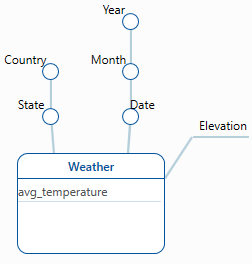

The procedure to create the cube is the following.

1. On the stations file:
  1. replace empty states and countries in stations with a placeholder value (e.g., "XX");
  1. keep only the following fields: stationId, state, country, elevation
2. On the weather-sample file:
  1. filter out weather wrong measurements (i.e., where airTemperatureQuality=9);
  1. keep only the following fields: stationId, airTemperature, date, month, year
  1. create a new fulldate field by concatenating year, month, and date
  1. create a new fullmonth field by concatenating year and month
1. Join stations with weather measurements on the stationId field
1. Keep only the following fields: state, country, elevation, fulldate, fullmonth, year, airTemperature
1. Aggregate the measurements by state and date to take the average temperature
  - Group by: state, country, elevation, fulldate, fullmonth, year
  - Calculation: avg(airTemperature)
1. Save the result on a file

In [ ]:
!wget https://raw.githubusercontent.com/w4bo/2023-bbs-dm/master/materials/datasets/weather-stations.csv
!wget https://raw.githubusercontent.com/w4bo/2023-bbs-dm/master/materials/datasets/weather-sample-10k.txt

## Spark

In [ ]:
dfW = sc.textFile("weather-sample-10k.txt")\
  .map(lambda l: (l[4:15],l[15:19],l[19:21],l[21:23],int(l[87:92])/10,l[92:93]))\
  .toDF(["stationId","year","month","day","airTemperature","airTemperatureQuality"])
dfW.show()

In [ ]:
from pyspark.sql.functions import concat
dfS = spark.read.option("delimiter", ",").option("header", "false").csv("weather-stations.csv")
dfS = dfS.select(concat(dfS[0],dfS[1]),dfS[2],dfS[3],dfS[4],dfS[5],dfS[6],dfS[7],dfS[8],dfS[9],dfS[10])\
  .toDF("stationId","city","country","state","call","latitude","longitude","elevation","date_begin","date_end")
dfS.show()

1. On the stations file:
  1. replace empty states and countries in stations with a placeholder value (e.g., "XX");
  1. keep only the following fields: stationId, state, country, elevation

In [ ]:
dfS1 = dfS.fillna({'state': 'XX', 'country':'XX'})
dfS2 = dfS1.select('stationId','state','country','elevation')
dfS2.show()

2. On the weather-sample file:
  1. filter out weather wrong measurements (i.e., where airTemperatureQuality=9);
  1. keep only the following fields: stationId, airTemperature, date, month, year
  1. create a new fulldate field by concatenating year, month, and date
  1. create a new fullmonth field by concatenating year and month

In [ ]:
from pyspark.sql.functions import concat, lit
dfW1 = dfW.where("airTemperature < 9")
dfW2 = dfW1.select('stationId','airTemperature','day','month','year')
dfW3 = dfW2.withColumn("fulldate", concat(dfW1.year,lit("-"),dfW1.month,lit("-"),dfW1.day))
dfW4 = dfW3.withColumn("fullmonth", concat(dfW1.year,lit("-"),dfW1.month))
dfW4.show()

3. Join stations with weather measurements on the stationId field


In [ ]:
dfJ = dfS2.join(dfW4, "stationId")
dfJ.show()

4. Keep only the following fields: state, country, elevation, fulldate, fullmonth, year, airTemperature

In [ ]:
dfJ2 = dfJ.select("state", "country", "elevation", "fulldate", "fullmonth", "year", "airTemperature")
dfJ2.show()

5. Aggregate the measurements by state, country and date to take the average temperature
  - Group by: state, country, elevation, fulldate, fullmonth, year
  - Calculation: avg(airTemperature)

In [ ]:
dfG = dfJ2.groupBy("state", "country", "elevation", "fulldate", "fullmonth", "year").agg({'airTemperature': 'avg'})
dfG.show()

6. Save the result on a file

In [ ]:
dfG.write.mode('overwrite').option('header','true').csv("weather-cube")

## Power BI

Download the file from the left panel of this notebook (in case of issues, download it from [here](https://raw.githubusercontent.com/w4bo/2023-bbs-dm/master/materials/datasets/weather-cube.csv)) and load it in Power BI.
- (optional) Create the hierarchies
- Visualize the daily trend of average temperatures for each country
- Show the average temperature on the map
- Compute bins for the elevation field and show the average temperature for each bin


The final Power BI file will be available [here](https://raw.githubusercontent.com/w4bo/2023-bbs-dm/master/materials/results/weather-cube.pbix).

# Additional exercises

Carry out the following operations (in any order).

- Check if there exist stations with a negative elevation; then, calculate how many of these stations exist in each country; rename the result to "cnt" and order the result by decreasing cnt
- Take only stations with positive elevation, compute the maximum elevation by country and rename the result to "elevation"; then, join the result with the original dfS to get, for each country, the name of the city with the highest elevation (join key: ```["country","elevation"]```); order the result by decreasing elevation
- Take only weather values with airQuality==1, compute the minimum temperature for each stationId and rename it to "minTemperature"; then, join the result with dfS and keep only the columns "minTemperature" and "elevation"; finally, use the correlation between the two columns. To do the last part, you need to:
  - cast the elevation to an integer datatype: you need to add ```from pyspark.sql.types import IntegerType``` and then ```df.myfield.cast(IntegerType())```;
  - compute the correlation with ```df.stat.corr("myfield1","myfield2")```.

The solution will be available [here](https://raw.githubusercontent.com/w4bo/2023-bbs-dm/master/materials/results/03-SparkBasics-solution.ipynb).